# ARTIST CENTRALITY _part II_

## Learning from Networks - Project 2022-2023

## Group members : Crivellari Alberto, Khalili Navid, Sartor Nicolò

## Artists closeness: different methods to compute the centrality of nodes in a graph

In this second part we will study the closeness centrality of random graphs of G

### 1. Import libraries

In [1]:
import networkx as nx 
import time
import random as rnd
import math
import numpy.random
import pandas
import os
import matplotlib.pyplot as plt

#### 1.1. Create folder _results_

In [2]:
try :
    os.mkdir('results')
except :
    print('Folder already existing, nothing done')

Folder already existing, nothing done


### 2. Build Graph G
We build G as a subgraph with a 40 popularity filter of the graph in our dataset, then we remove nodes that aren't in the main connected component.

Add nodes to graph G from file __nodes.csv__

Remove duplicates from graph G, nodes with same IDs

Add edges to graph G from file __edges.csv__

Remove nodes that aren't in the main connected component

__PS: All these passages were done separately in the first notebook__

In [3]:
G = nx.Graph()

# Load dataset with nodes info
f = open('dataset/nodes.csv', "r", encoding="utf8")
f.readline()
discarded_counter=0
while True:
    line = f.readline().strip()
    if line == '':
        break
        
    current_id, tmp = line.split(',', 1)
    current_artist = current_followers = current_popularity = ''
    if tmp[0] != '"':
        current_artist, current_followers, current_popularity, tmp = tmp.split(',', 3)
    else:
        empty, current_artist, tmp = tmp.split('"', 2)
        empty, current_followers, current_popularity, tmp = tmp.split(',', 3)
    try:
        current_followers = int(float(current_followers))
        current_popularity = int(current_popularity)                
    except ValueError as ve:
        print('ValueError occured while converting string to int. Node ID:', current_id)
        discarded_counter += 1
        continue
    #popularity filter
    if current_popularity >= 40:
        if G.has_node(current_id):
            
            if G.nodes[current_id]['followers'] < current_followers:
                G.nodes[current_id]['followers'] = current_followers  
            if G.nodes[current_id]['popularity'] < current_popularity:
                G.nodes[current_id]['popularity'] = current_popularity
        else:
            G.add_node(current_id, artist=current_artist, followers=current_followers, popularity=current_popularity, path_sum=0)
f.close()     
print(discarded_counter,"nodes have been discarded because of bad formatting!")
print(G.number_of_nodes(),"nodes have been added successfully\n")

#Load dataset with edges info
f = open('dataset/edges.csv', "r", encoding="utf8")
f.readline()
while True:
    line = f.readline().strip()
    if line == '':
        break
    id_0, id_1 = line.split(',', 1)
    if G.has_node(id_0) and G.has_node(id_1):
        G.add_edge(id_0, id_1) 
f.close()
print(G.number_of_edges(),"edges have been added successfully\n")

print(G.number_of_nodes(),"nodes before clean up")
print(G.number_of_edges(),"edges before clean up")
nodes_main_component = max(nx.connected_components(G), key=len)
G = G.subgraph(nodes_main_component)
print(G.number_of_nodes(),"nodes after clean up")
print(G.number_of_edges(),"edges after clean up\n")

ValueError occured while converting string to int. Node ID: 4Jgl9FmNQF6ontIRyY19Ig
ValueError occured while converting string to int. Node ID: 3cCFieWefBXyyDRsjNuArE
ValueError occured while converting string to int. Node ID: 1lLHQcDQFM03FcxZ5mQimA
ValueError occured while converting string to int. Node ID: 7ti7Mdu4BTfKOYWcI1Q6h8
ValueError occured while converting string to int. Node ID: 7estJE1m5cJnQs3Rc4iar0
5 nodes have been discarded because of bad formatting!
28621 nodes have been added successfully

118141 edges have been added successfully

28621 nodes before clean up
118141 edges before clean up
26389 nodes after clean up
117766 edges after clean up



### 3. Function for Approximate Closeness Centrality (Eppstein-Wang)

In [4]:
def ApproximateClosenessCentrality_EW(G, k):
    #make sure lable sum is equals to 0 for every node
    for n in G:
        G.nodes[n]['path_sum'] = 0
        
    for i in range(k):
        #pick one node uniformally at random
        random_node = rnd.choice(list(G.nodes()))
        #solve sssp with picked node as source
        sssp = nx.shortest_path_length(G, source=random_node)
        #update partial sum of distancies for each node
        for n, path_lenght in sssp.items():
            G.nodes[n]['path_sum'] += path_lenght
    centralities = {}
    #compute final approximation of centrality for each node
    for n in G:
        if G.nodes[n]['path_sum'] == 0:
            centralities[n] = 0
        else:
            centralities[n] = 1/((G.number_of_nodes()*G.nodes[n]['path_sum'])/(k*(G.number_of_nodes()-1)))
    #return dicionary containg pairs (node, approximatedcentrality)
    return centralities      

### 4. Compute Approximate Closeness Centrality on our graph G

#### 4.1. Calculate k using epsilon 0.1
We use epsilon = 0.1 to calculate the k 

In [5]:
k = int(math.log(G.number_of_nodes(),2)/0.01)

#### 4.2. Compute approximate closeness centralities of G __[15min]__
We use the function of Eppstein-Wang 

In [6]:
start_time = time.time()
approximated_closeness_centrality_EW = ApproximateClosenessCentrality_EW(G,k)
end_time = time.time()

#let's sort the results based on the value
approximated_closeness_centrality_EW = {k: v for k, v in sorted(approximated_closeness_centrality_EW.items(), reverse=True, key=lambda item: item[1])}

#let's print the results
#print(approximated_closeness_centrality_EW_2)
print("the approximated closeness centralities with %s iterations have been computed in %s seconds" %(k, end_time - start_time))

#Let's store the results
f = open('results/results_approximated_closeness_centrality_EW_epsilon_0_01.txt', "w", encoding="utf8")
for key, value in approximated_closeness_centrality_EW.items():
    f.write('%s:%s\n' %(key, value))
    
# Close opened file
f.close()

the approximated closeness centralities with 1468 iterations have been computed in 812.6388809680939 seconds


#### 4.3. Compute mean of the approximate closeness centralities of G

In [7]:
mean_graphG_centralities = 0
for n in G :
        mean_graphG_centralities += approximated_closeness_centrality_EW[n]
mean_graphG_centralities = mean_graphG_centralities/G.number_of_nodes()

### 5. Generate random graphs of G and run Approximate Closeness Centrality on them

We want to know if our closeness centrality measure is significant.

To do so we randomly generate graphs with as much nodes and edges as our graph G, making sure that the graph that we obtain is connected, then we compute the stats for these graphs and compare them with the stats of G.

We store the number of random graphs in a variable.

In [8]:
number_of_random_graphs = 200

#### 5.1. Model G(n,p) __[2hours]__
Let's start by generating (_number of random graphs_/2) random graphs.

We use G(n,p) as the model of random graphs.

Then we compute the closeness centrality with Eppstein-Wang, with epsilon = 0.1.

In [9]:

#let's compute the probability of an edge as number of edges over possible number of edges
probability = G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1)/2)
all_mean_random_centralities=[]
start_time = time.time()
for i in range(int(number_of_random_graphs/2)):
    #Let's now inizialize the random graph (as seed we use a pseudo-random number)
    random_G = nx.fast_gnp_random_graph(G.number_of_nodes(), p = probability, seed = rnd.randrange(10000))
    
    #If the first graph we generated is not connected we keep generating graphs until we find a connected graph
    while not nx.is_connected(random_G):
        random_G = nx.fast_gnp_random_graph(G.number_of_nodes(), p = probability, seed = rnd.randrange(10000))
    
    #We calculate k with epsilon = 0.1, using random_G number of nodes 
    k = int(math.log(random_G.number_of_nodes(),2)/0.01)
    
    #Now that we generated the graph and we have k we compute the approximated centralities with Eppstein-Wang algorithm
    approximated_closeness_centrality_random = ApproximateClosenessCentrality_EW(random_G,k)
    
    #let's sort the results based on the value
    approximated_closeness_centrality_random = {k: v for k, v in sorted(approximated_closeness_centrality_random.items(),reverse=True , key=lambda item: item[1])}

    #Let's store the results and compute the sum of all the centralities that we will use later to compute the mean
    mean_random_centralities = 0
    f = open(f'results/results_approximated_closeness_centrality_random_{i+1}.txt', "w", encoding="utf8")
    for key, value in approximated_closeness_centrality_random.items():
        f.write('%s:%s\n' %(key, value))
        mean_random_centralities += value
    mean_random_centralities = mean_random_centralities/random_G.number_of_nodes()
    
    #Let's store it
    all_mean_random_centralities.append(mean_random_centralities)
end_time = time.time()
print(f"The approx. closeness centralities with %s iterations of the {i+1} random graph with the G(n,p) model have been computed in : %d seconds" %(k, end_time - start_time))

The approx. closeness centralities with 1468 iterations of the 100 random graph with the G(n,p) model have been computed in : 7396 seconds


#### 5.2. Chung-Lu Model __[2hours]__
Now we generate (_number of random graphs_/2) random graphs with the Chung-Lu model (taking in consideration degree of nodes).

If the returned graph is not connected we randomly add enough edges to make the graph connected

In [10]:
expected_degrees = []
for n in G:
    expected_degrees.append(G.degree[n])

all_mean_random_degree_centralities=[]
start_time = time.time()
for i in range(int(number_of_random_graphs/2)):
    #Let's now inizialize the random graph, as seed we use a pseudo-random number
    random_degree_G = nx.expected_degree_graph(expected_degrees, seed=rnd.randrange(10000), selfloops=False)
    
    #If the graph we generated is not connected we randomly add enough edges to make it connected
    if not nx.is_connected(random_degree_G):
        random_degree_G = nx.expected_degree_graph(expected_degrees, seed=rnd.randrange(10000), selfloops=False)
    
    #Now that we generated the graph we need to compute the approximated centraliteis
    approximated_closeness_centrality_random_degree = ApproximateClosenessCentrality_EW(random_degree_G,k)
    
    #let's sort the results based on the value
    approximated_closeness_centrality_random_degree = {k: v for k, v in sorted(approximated_closeness_centrality_random_degree.items(),reverse=True , key=lambda item: item[1])}

    #Let's compute the sum of all the centralities that we will use later to compute the mean
    mean_random_degree_centralities = 0
    f = open(f'results/results_approximated_closeness_centrality_random_wiht_same_degree_{i+1}.txt', "w", encoding="utf8")
    for key, value in approximated_closeness_centrality_random_degree.items():
        f.write('%s:%s\n' %(key, value))
        mean_random_degree_centralities += value
    mean_random_degree_centralities = mean_random_degree_centralities/random_degree_G.number_of_nodes()
    
    #let's store it
    all_mean_random_degree_centralities.append(mean_random_degree_centralities)
end_time = time.time()
print(f"The approx. closeness centralities with %s iterations of the {i+1} random graph with the Chung-Lu model have been computed in : %d seconds" %(k, end_time - start_time))

The approx. closeness centralities with 1468 iterations of the 100 random graph with the Chung-Lu model have been computed in : 4754 seconds


### 6. Store means of closeness centralities in a file
We store them in the file _statistics2.txt_

In [11]:
stats_file2 = open('results/statistics2.txt', "w", encoding="utf8")
stats_file2.write(f"The mean of the approximated centralities of the graphG is: {mean_graphG_centralities}\n")
for i in range(int(number_of_random_graphs/2)) :
    stats_file2.write(f"The mean of the approximated centralities of the {i+1} random graph is: {all_mean_random_centralities[i]}\n")
    stats_file2.write(f"The mean of the approximated centralities of the {i+1} random graph that takes in consideration the degree of the nodes is: {all_mean_random_degree_centralities[i]}\n")
stats_file2.close()

### 7. Compute z-scores to assess significance of our closeness centralities of G
To do so we need our feature f, the mean of the approximate closeness centrality of G, then we need the mean of random graphs measures and the variance of the random graphs measures.

We do it for the 2 types of random graphs, obtaining 2 z-scores. (G(n,p) model and Chung-Lu model)

In [12]:
mean = mean_graphG_centralities

mean_gnp = sum(all_mean_random_centralities)/len(all_mean_random_centralities)
variance_gnp = 0
for i in all_mean_random_centralities :
    variance_gnp += (i - mean_gnp)**2
variance_gnp = (variance_gnp / (len(all_mean_random_centralities)-1))**0.5


mean_chunglu = sum(all_mean_random_degree_centralities)/len(all_mean_random_degree_centralities)
variance_chunglu = 0
for i in all_mean_random_degree_centralities :
    variance_chunglu += (i - mean_chunglu)**2
variance_gnp = (variance_chunglu / (len(all_mean_random_degree_centralities)-1))**0.5

z_score_gnp = (mean - mean_gnp)/variance_gnp
z_score_chunglu = (mean - mean_chunglu)/variance_chunglu

print('z-score for G(n,p) model is : ', (z_score_gnp))
print('z-score for Chung-Lu model is : ', (z_score_chunglu))

z-score for G(n,p) model is :  -0.06464258577803932
z-score for Chung-Lu model is :  -0.21967501361850275


### 8. Compute p-values as a secondary measure to assess significance of our closeness centralities of G

In [13]:
pvalue_gnp = 0
pvalue_chunglu = 0

for i in range(int(number_of_random_graphs/2)) :
    if mean_gnp >= mean and all_mean_random_centralities[i] < mean :
        pvalue_gnp += 1
    if mean_gnp < mean and all_mean_random_centralities[i] >= mean :
        pvalue_gnp += 1
        
    if mean_chunglu >= mean and all_mean_random_degree_centralities[i] < mean :
        pvalue_chunglu += 1
    if mean_chunglu < mean and all_mean_random_degree_centralities[i] >= mean :
        pvalue_chunglu += 1
        
pvalue_gnp = pvalue_gnp / len(all_mean_random_centralities)
pvalue_chunglu = pvalue_chunglu / len(all_mean_random_degree_centralities)

print('p-value for G(n,p) model is : ', (pvalue_gnp))
print('p-value for Chung-Lu model is : ', (pvalue_chunglu))

p-value for G(n,p) model is :  0.0
p-value for Chung-Lu model is :  0.0


### 9. Print results in a table

In [14]:
# We also compute standard deviation of approx. algorithm on original graph G for completeness
variance_original_graph = 0
for i in approximated_closeness_centrality_EW :
    variance_original_graph += (approximated_closeness_centrality_EW[i] - mean)**2 
variance_original_graph = (variance_original_graph / (len(approximated_closeness_centrality_EW)-1))**0.5

In [15]:
table = {'Means': [mean, mean_gnp, mean_chunglu], 'Standard Deviations' : [variance_original_graph, variance_gnp, variance_chunglu], 'z-scores' : ['\\', z_score_gnp, z_score_chunglu], 'p-values' : ['\\', pvalue_gnp, pvalue_chunglu]}

pandas.DataFrame(data = table, index = ['Original graph G', 'Random graphs - G(n,p)', 'Random graphs - ChungLu'])

,Means,Standard Deviations,z-scores,p-values
Original graph G,0.196942,0.029168,\,\
"Random graphs - G(n,p)",0.204621,0.118801,-0.064643,0.0
Random graphs - ChungLu,0.503881,1.397244,-0.219675,0.0


#### From the table we can see from z-scores and p-values that our result is statistically significant.

### 9.1. Plot random graphs' means, to see their distribution 

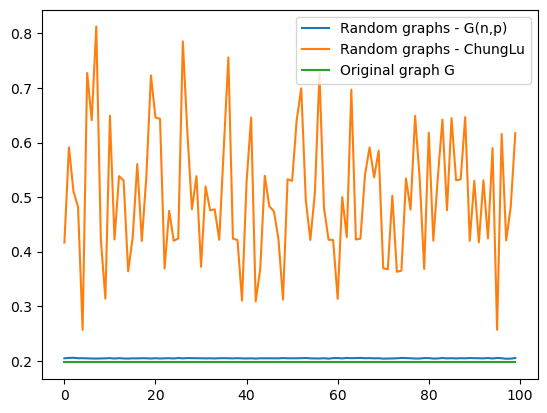

In [17]:
plt.plot(all_mean_random_centralities, label = 'Random graphs - G(n,p)')
plt.plot(all_mean_random_degree_centralities, label = 'Random graphs - ChungLu')
list_mean = []
for i in range(int(number_of_random_graphs/2)) :
    list_mean.append(mean)
plt.plot(list_mean, label = 'Original graph G')
plt.legend()